## Understanding Data

You are given 5 years of store-item sales data, and asked to predict 3 months of sales for 50 different items at 10 different stores.

Data fields

* date - Date of the sale data. There are no holiday effects or store closures.
* store - Store ID
* item - Item ID
* sales - Number of items sold at a particular store on a particular date.


In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score, GridSearchCV
import datetime as dt

plt.rcParams["figure.figsize"] = (15,5)


In [2]:
data = pd.read_csv('train.csv',parse_dates =['date'],index_col=['date'])
data.head()

,store,item,sales
date,,,
2013-01-01,1,1,13
2013-01-02,1,1,11
2013-01-03,1,1,14
2013-01-04,1,1,13
2013-01-05,1,1,10


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 913000 entries, 2013-01-01 to 2017-12-31
Data columns (total 3 columns):
store    913000 non-null int64
item     913000 non-null int64
sales    913000 non-null int64
dtypes: int64(3)
memory usage: 27.9 MB


## Base model

We have chosen Decision Tree Regressor as our base model. SMAPE (symmetric mean absolute percentage error) is our performance metric for this project. SMAPE is less sensitive to outliers and invariant to linear scaling. It has been observed that sales has right skewed distribution, hence we are considering it's log transform as it gives more approximate standard distribution for it.

(52.250286966046005, 47.0, 0, 231)

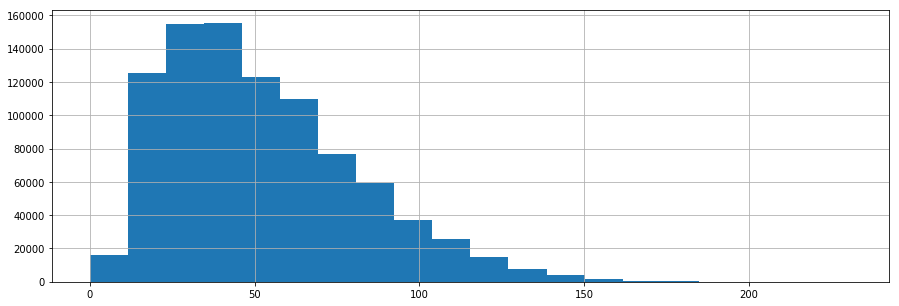

In [4]:
data['sales'].hist(bins = 20)
mean = data['sales'].mean()
median = np.median(data['sales'])
minimum = data.sales.min()
maximum = data.sales.max()

mean,median,minimum,maximum

(3.820443080112928, 3.8712010109078907)

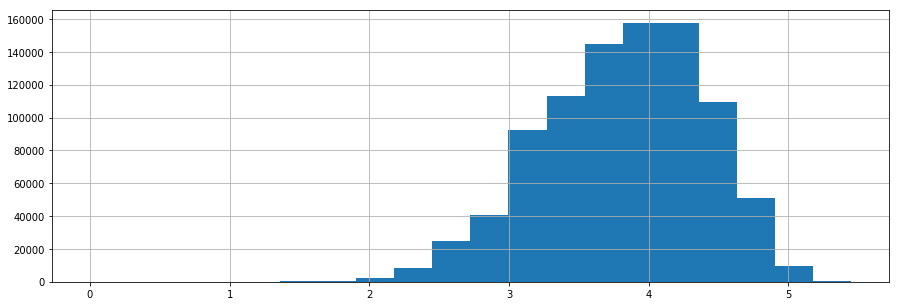

In [5]:
logged = np.log1p(data['sales'])
logged.hist(bins = 20)
logged.mean(),logged.median()

In [6]:
def smape(actual,predict,islog=True):
    if islog == True:
        actual = np.exp(actual) - 1
        predict = np.exp(predict) -1
        
    return 100*np.mean(2*np.abs(actual-predict)/(np.abs(actual)+np.abs(predict)))
    
smape_score = make_scorer(smape,greater_is_better=False)

def evaluate_model(df,features):
    all_X = df[features]
    all_y = np.log1p(df['sales'])
    
    tree = DecisionTreeRegressor(random_state = 1)
    scores = cross_val_score(tree,all_X,all_y,scoring=smape_score,cv=5)
    avg_score = -(scores.mean())  # avoid negative sign which caused due to make_scorer
    
    return avg_score

## Step 1: EDA with available Features

Our EDA shows that sales vary with store and item. Hence these features can play important role in predictions.In this step we will train our base model with available features and evaluate the performance.

Text(0.5, 1.0, 'itemwise sale')

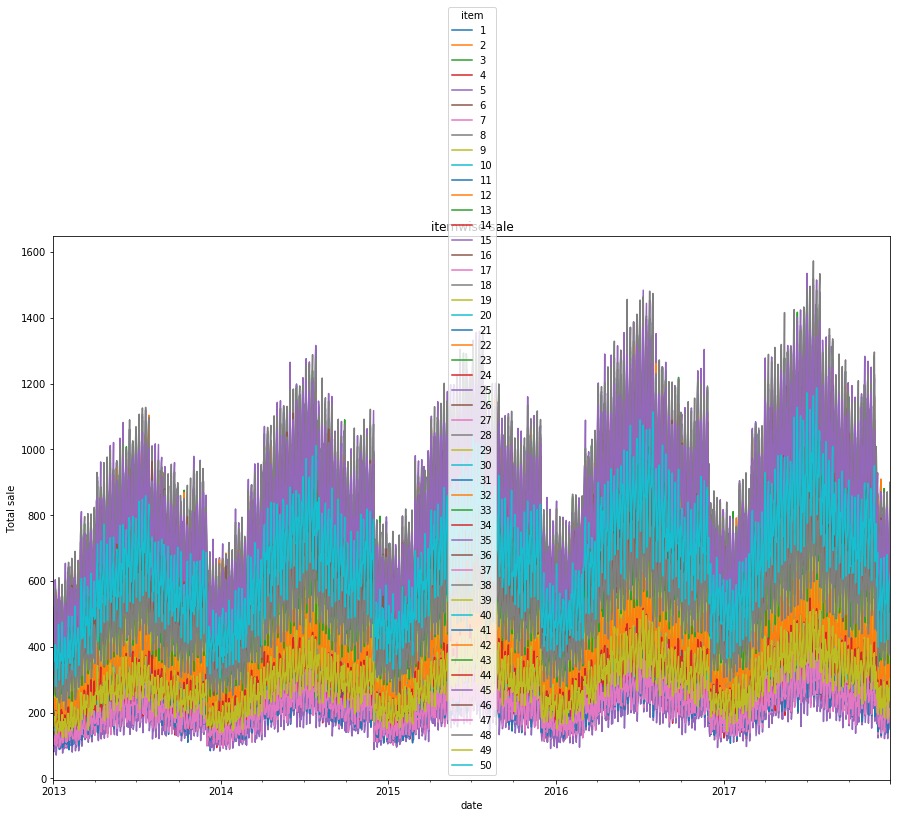

In [7]:
df = data.groupby(['date','item'])['sales'].sum().unstack()
df.plot(figsize=(15,10))
plt.ylabel('Total sale')
plt.title('itemwise sale')

Text(0.5, 1.0, 'Total sale store wise')

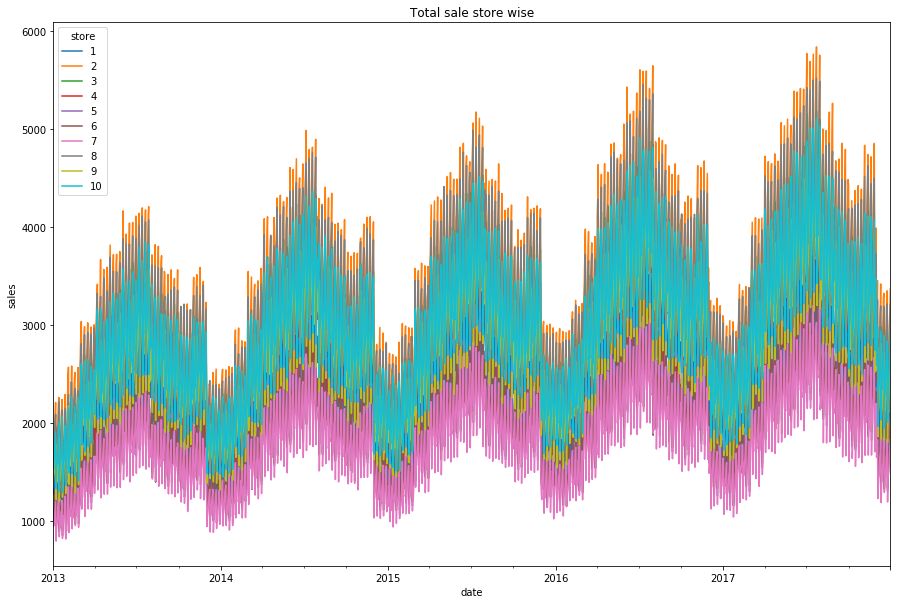

In [8]:
df = data.groupby(['date','store'])['sales'].sum().unstack()
df.plot(figsize=(15,10))
plt.ylabel('sales')
plt.title('Total sale store wise')

In [9]:
features = list(data.columns)
features.remove('sales')
print('SMAPE with available features: {:.4f}'.format(evaluate_model(data,features)))

SMAPE with available features: 47.6577


Cross validation SMAPE score for this step is 47.66

## Step 2: EDA and Basic Feature Engineering

In this step we will extract common features like month, year, day, week etc. from date column and analyse sales variation over the period w.r.t. these features. 

In [10]:
data['month'] = data.index.month
data['year'] = data.index.year
data['dow'] = data.index.dayofweek
data['day'] = data.index.day
data['quarter'] = data.index.quarter
data['week'] = data.index.week

data.head()

,store,item,sales,month,year,dow,day,quarter,week
date,,,,,,,,,
2013-01-01,1,1,13,1,2013,1,1,1,1
2013-01-02,1,1,11,1,2013,2,2,1,1
2013-01-03,1,1,14,1,2013,3,3,1,1
2013-01-04,1,1,13,1,2013,4,4,1,1
2013-01-05,1,1,10,1,2013,5,5,1,1


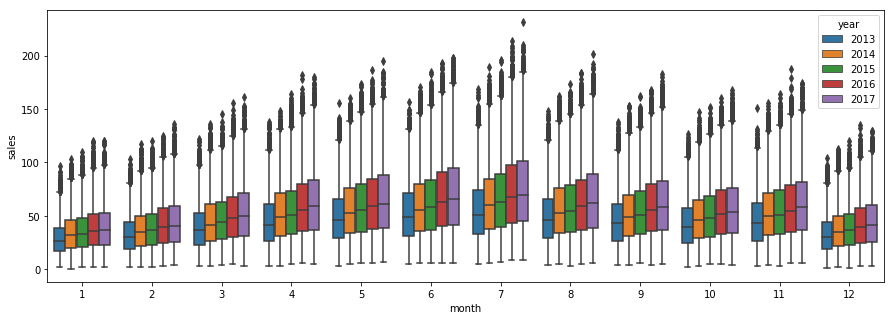

In [11]:
sns.boxplot(x='month',y='sales',hue = 'year', data=data)

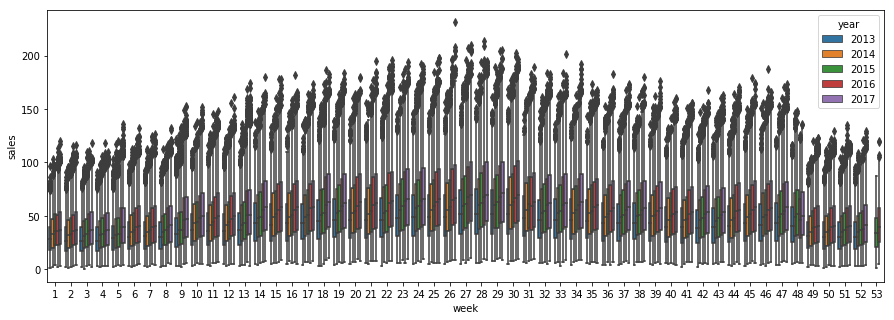

In [12]:
sns.boxplot(x='week',y='sales',hue ='year', data=data)

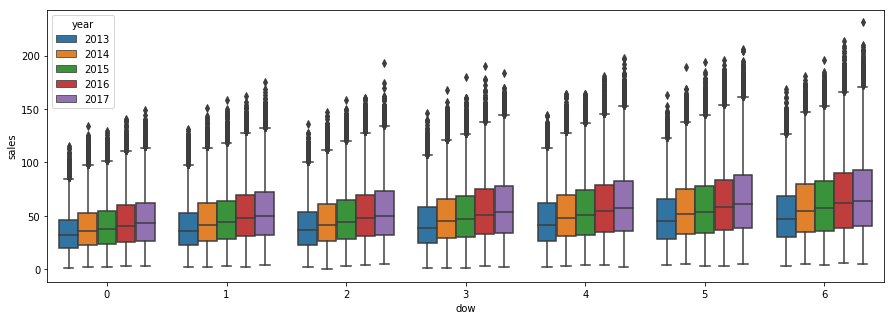

In [13]:
sns.boxplot(x='dow',y='sales',hue ='year', data=data)

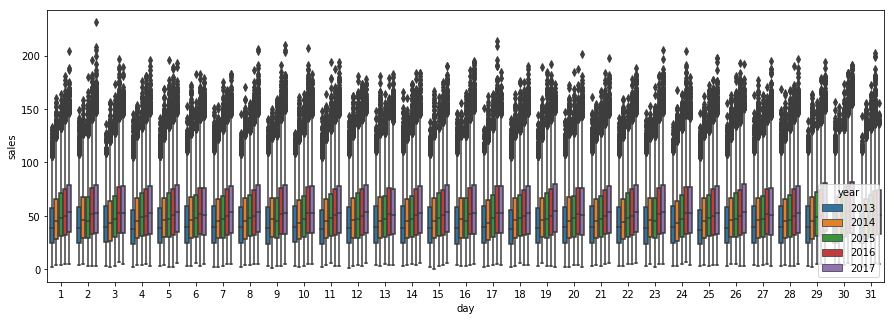

In [14]:
sns.boxplot(x='day',y='sales',hue ='year', data=data)

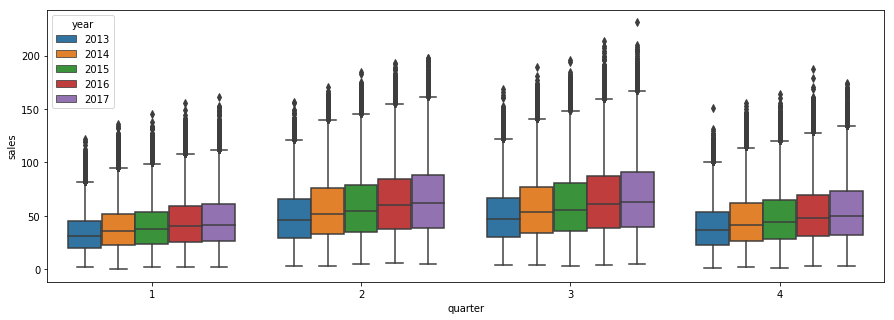

In [15]:
sns.boxplot(x='quarter',y='sales',hue ='year', data=data)

Observations:
1. Overall sale seems to be increasing with the year
2. Overall sale is high 
 - during may,june,july in a year
 - during weekend in a week 
 - Mostly in a 3rd quarter
3. sales vary slightly w.r.t to day of month
 

In [16]:
features = list(data.columns)
features.remove('sales')
print('SMAPE with Basic feature engineering: {:.4f}'.format(evaluate_model(data,features)))

SMAPE with Basic feature engineering: 45.1346


With basic feature engineering we have lowered cross validation SMAPE score by 2.

## Step 3: EDA and Advance Feature Engineering

Sometime even with the available features tree based models fails to extract interaction between them and result in large number of splits and more complex model. In this context we would develope some features which extract features interaction and ease the job for decision tree to make more accurate prediction. 

We would develop feature for following interactions

1. **store and item: **
   sales could differ for particular item in different locations. It means that, though a item could be very popular but sales could be less if store located far away from residential area. Reverse is true for store. i.e. store could be at main location but if item is not so popular the sale could be low

2. **week and dow: **
   combination of these two features may give sense of order to decision tree regressor
   
3. **year and month: ** same as above

In [17]:
store_item_df = pd.pivot_table(data, index='item', values='sales', columns='store',margins=True, aggfunc=np.mean)
store_item_df.head()

store,1,2,3,4,5,6,7,8,9,10,All
item,,,,,,,,,,,
1,19.971522,28.173604,25.070099,22.938664,16.739321,16.717963,15.159365,26.983571,23.325849,24.736035,21.981599
2,53.148959,75.316539,66.804491,61.715225,44.488499,44.533954,40.717963,71.656627,61.792442,65.566813,58.574151
3,33.208105,46.992333,41.771084,38.548193,27.835706,27.811062,25.531216,45.076123,38.535049,41.113363,36.642223
4,19.956188,28.234940,25.116101,23.086528,16.776561,16.754107,15.358160,26.948521,23.150055,24.721249,22.010241
5,16.612815,23.540526,20.857612,19.525192,14.086528,13.893209,12.733844,22.427711,19.272180,20.637459,18.358708


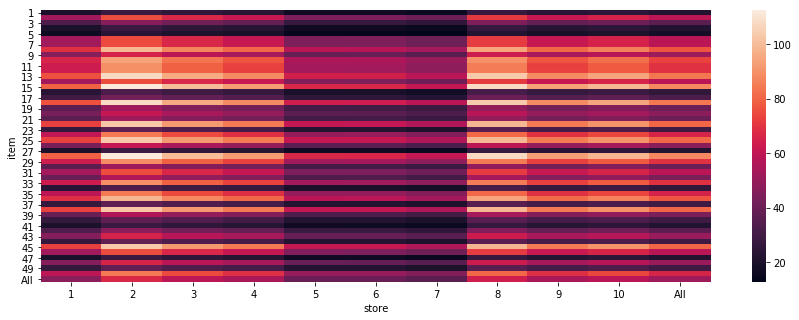

In [18]:
sns.heatmap(store_item_df)

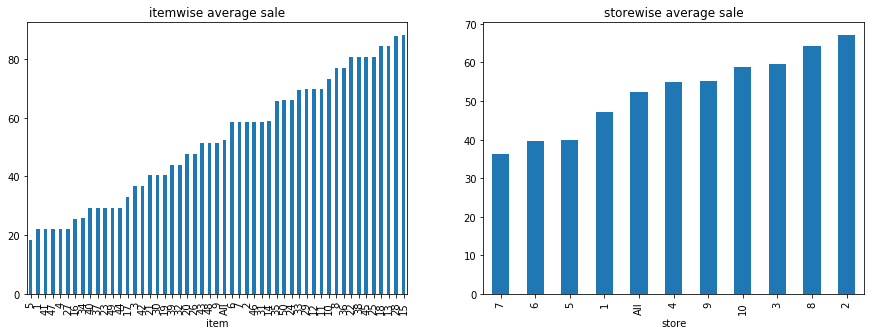

In [19]:
fig,(ax1,ax2) = plt.subplots(1,2, figsize = (15,5))
store_item_df['All'].sort_values().plot.bar(ax=ax1, title ='itemwise average sale' )
store_item_df.loc['All',:].sort_values().plot.bar(ax=ax2, title = 'storewise average sale')

In [20]:
i = store_item_df['All'].sort_values().index
c = store_item_df.loc['All',:].sort_values().index
store_item_df = store_item_df[c]
store_item_df = store_item_df.reindex(i)

store_item_df.drop('All',axis=1,inplace=True)
store_item_df.drop('All',axis=0,inplace = True)

store_item_df.head()


store,7,6,5,1,4,9,10,3,8,2
item,,,,,,,,,,
5,12.733844,13.893209,14.086528,16.612815,19.525192,19.272180,20.637459,20.857612,22.427711,23.540526
1,15.159365,16.717963,16.739321,19.971522,22.938664,23.325849,24.736035,25.070099,26.983571,28.173604
41,15.471522,16.607338,16.830778,20.002738,23.168127,23.191128,24.654984,24.989047,27.036145,28.069551
47,15.479189,16.708653,16.699343,19.814348,23.114458,23.003286,24.755750,25.120482,27.150055,28.187842
4,15.358160,16.754107,16.776561,19.956188,23.086528,23.150055,24.721249,25.116101,26.948521,28.234940


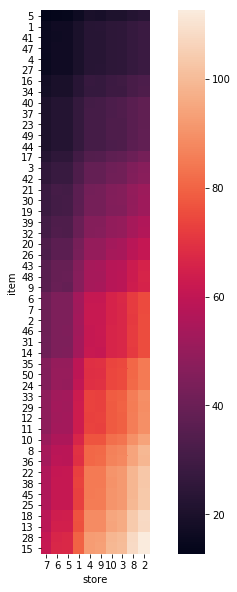

In [21]:
plt.figure(figsize=(10,10))
sns.heatmap(store_item_df, square=True)

From above heatmap we can see that store item are very well organized w.r.t their sales. Each block in heatmap shows the average sales for particular item in particular store. Row number defines that particular item and column number defines that particular store.Lowest value for avg sale is situated in topleft corner and highest value is at bottom right corner. And average sales seems to be increasing along the column and then along the row. if we encode store item combination accordingly it would grately helps our regressor for making prediction.

In [22]:
# Prepare dataframe to encode store item interaction
encode_df = pd.DataFrame(np.arange(1,501,1).reshape((50,10)))
encode_df.columns = store_item_df.columns
encode_df.index = store_item_df.index


In [23]:
def encode_feature(row):
    r = row['item']
    c = row['store']
    return encode_df.loc[r,c]

data['store_item'] = data.apply(encode_feature,axis=1)

data.head()

,store,item,sales,month,year,dow,day,quarter,week,store_item
date,,,,,,,,,,
2013-01-01,1,1,13,1,2013,1,1,1,1,14
2013-01-02,1,1,11,1,2013,2,2,1,1,14
2013-01-03,1,1,14,1,2013,3,3,1,1,14
2013-01-04,1,1,13,1,2013,4,4,1,1,14
2013-01-05,1,1,10,1,2013,5,5,1,1,14


In [24]:
features = list(data.columns)
features.remove('sales')

print('SMAPE with feature engineering step 3: {:.4f}'.format(evaluate_model(data,features)))

SMAPE with feature engineering step 3: 18.6727


For other two interactions we will contenate year with month as its fraction and week with days as its fraction

In [25]:
data['m_yr'] = data['year'] + data['month']/100
data['week_frac'] = data['week'] + data['dow']/100
data.head()

,store,item,sales,month,year,dow,day,quarter,week,store_item,m_yr,week_frac
date,,,,,,,,,,,,
2013-01-01,1,1,13,1,2013,1,1,1,1,14,2013.01,1.01
2013-01-02,1,1,11,1,2013,2,2,1,1,14,2013.01,1.02
2013-01-03,1,1,14,1,2013,3,3,1,1,14,2013.01,1.03
2013-01-04,1,1,13,1,2013,4,4,1,1,14,2013.01,1.04
2013-01-05,1,1,10,1,2013,5,5,1,1,14,2013.01,1.05


In [26]:
drop_col = ['sales'] # 'year','day','month','dow','week','store','item',

features = list(data.columns)
for i in drop_col:
    features.remove(i)
    
evaluate_model(data,features)

18.637692200197517

We have tremendously improved our base model performance by this advance feature engineering. The SMAPE is lowered by almost 60% of it's value at previous step.

## Hyperparameter Tuning:
We will apply standard grid search method to our base model to optimize its important hyperparameters. It helped us to improve the performance further.

In [27]:
h = {'criterion' : ['mse','friedman_mse'],
                   'min_samples_leaf': [1,3,5],
                   'min_samples_split': [2,4,6]
                  }


dtr = DecisionTreeRegressor(random_state=1)
grid = GridSearchCV(dtr, param_grid=h, scoring=smape_score, cv=5, verbose=10, n_jobs =-1)

all_X = data[features]
all_y = np.log1p(data['sales'])
grid.fit(all_X,all_y)
        
pred = grid.predict(data[features])
pred = [max(0,p) for p in pred]

error = smape(all_y,pred,islog=True)

print('SMAPE on Last Step: {:.4f}'.format(error))




Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   27.6s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   43.0s
/opt/conda/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   54.0s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  3.0min finished


SMAPE on Last Step: 10.4830


## Implementation of model for Final Test Set

In [28]:
def transform_feature(df):
    
    # Apply basic feature engineering
    df['month'] = df.index.month
    df['year'] = df.index.year  
    df['dow'] = df.index.dayofweek
    df['day'] = df.index.day
    df['quarter'] = df.index.quarter
    df['week'] = df.index.week
    
    # Apply advance feature engineering
    df['store_item'] = df.apply(encode_feature,axis=1)
    df['m_yr'] = df['year']+df['month']/100
    df['week_frac'] = df['week']+df['dow']/100
    
    return df
    
    

In [29]:
holdout = pd.read_csv('test.csv',parse_dates =['date'],index_col=['date'])
ids= holdout['id']
holdout = transform_feature(holdout)

pred_h = grid.predict(holdout[features])
pred_h = np.exp(pred_h)-1
pred_h = [max(0,p) for p in pred_h]

submission_df = {'id':ids, 'sales':pred_h}
submission =pd.DataFrame(submission_df)

submission.to_csv('submission.csv',index=False)



**Test score : 14.80 **

## Summary: 
We have implemented store demand forecast which forecast sales of item at different store. We have trained model on five years of data and tested over next three months. Our test SMAPE score is 14.80. The aim of the project is to step by step improvement to our base model through basic to advance feature engineering and hyperparameter tuning. We have started with very simple decision tree regressor model with available feature which provided us SMAPE score 47.66. With feature engineering step we have reduced it to 18.63 and further hyperparameter tuning reduced it to 10.48.